In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode

%matplotlib notebook

- acepta_permuta : (bool) abierto a la posibilidad de permutar por otro bien u objeto
- agency : Inmobiliaria
- altura_permitida : Condiciones de la propiedad para contruir edificios, segun norma local.
- ambientes : Nunero de ambientes de la propiedad asociados a uso de oficina o local comercial.
- ambientes_extra : (bool) Si tiene 7 o mas abientes 
- ano_de_construccion : Año de  cosntrucción de la propiedad. 
- aptos_por_piso : 
- banos : 
- banos_extra : 
- cantidad_de_pisos : 
- casco : 
- description : 
- direccion : 
- disposicion : 
- distancia_al_mar : 
- dormitorios : 
- dormitorios_extra : 
- estado : 
- extra : 
- financia : 
- garajes : 
- garajes_extra : 
- gastos_comunes : 
- gastos_comunes_cur : 
- hectareas : 
- huespedes : 
- kind : 
- longitud_frente : 
- m2_de_la_terraza : 
- m2_del_terreno : 
- m2_edificados : 
- oficina : 
- penthouse : 
- piso : 
- plantas : 
- plantas_extra : 
- price : 
- price_cur : 
- referencia : 
- sobre : 
- tipo_propiedad : 
- title : 
- url : 
- vista_al_mar : 
- vivienda_social : 
- zona : - 

In [3]:
df = pd.read_csv('../data/preprocessed/details_home_for_sale_dataset_2019-07-25.csv')


In [42]:
df_obj = (df
          .select_dtypes(include='object')
          .fillna('')
          .apply(lambda x: x.str.lower().apply(lambda y: unidecode(y)))
         )
df_num = df.select_dtypes(exclude='object')
df_raw = pd.concat([df_num, df_obj], axis=1)

In [44]:
# df_raw['tipo_propiedad'].unique()

In [10]:
mask = (
    df_raw['tipo_propiedad'].isin(['apartamentos', 'casas'])
    & (df_raw['oficina'] != 1)
    & (df_raw['penthouse'] != 1) 
)
df_raw = df_raw[mask]
df_raw.columns

Index(['acepta_permuta', 'altura_permitida', 'ambientes', 'ambientes_extra',
       'ano_de_construccion', 'aptos_por_piso', 'banos', 'banos_extra',
       'cantidad_de_pisos', 'casco', 'distancia_al_mar', 'dormitorios',
       'dormitorios_extra', 'financia', 'garajes', 'garajes_extra',
       'gastos_comunes', 'gastos_comunes_cur', 'hectareas', 'huespedes',
       'longitud_frente', 'm2_de_la_terraza', 'm2_del_terreno',
       'm2_edificados', 'oficina', 'penthouse', 'piso', 'plantas',
       'plantas_extra', 'price', 'price_cur', 'vista_al_mar',
       'vivienda_social', 'agency', 'description', 'direccion', 'disposicion',
       'estado', 'extra', 'kind', 'referencia', 'sobre', 'tipo_propiedad',
       'title', 'url', 'zona'],
      dtype='object')

In [11]:
columns = ['ano_de_construccion', 'banos', 'disposicion', 'dormitorios',
           'estado', 'garajes', 'gastos_comunes',
           'm2_de_la_terraza', 'm2_del_terreno', 'm2_edificados',
           'price', 'tipo_propiedad', 'vivienda_social', 'zona']

In [12]:
df_selected = df_raw[columns].reset_index(drop=True)
fill_zero_col = ['m2_de_la_terraza', 'vivienda_social', 'gastos_comunes', 'garajes']
df_selected.loc[:, fill_zero_col] = df_selected.loc[:, fill_zero_col].fillna(0)
mask_m2_terreno = df_selected['m2_del_terreno'].isna()
df_selected.loc[mask_m2_terreno, 'm2_del_terreno'] = df_selected.loc[mask_m2_terreno, 'm2_edificados']
(
    df_selected
    .isna()
    .sum()
)

ano_de_construccion    7664
banos                    73
disposicion               0
dormitorios              33
estado                    0
garajes                   0
gastos_comunes            0
m2_de_la_terraza          0
m2_del_terreno          827
m2_edificados           934
price                    70
tipo_propiedad            0
vivienda_social           0
zona                      0
dtype: int64

In [13]:
df_selected.dropna(inplace=True)

In [14]:
df_num_selected = df_selected.select_dtypes(exclude='object')
df_obj_selected = df_selected.select_dtypes(include='object')

In [39]:
import pandas_profiling
report = pandas_profiling.ProfileReport(df_num_selected)
report.to_file('../report/dataset/report_numeric.html')

In [15]:
df_obj_selected.sample(5)

,disposicion,estado,tipo_propiedad,zona
11412,al frente,excelente estado,apartamentos,pocitos
17399,al frente,excelente estado,casas,jacinto vera
151,al frente,buen estado,casas,sayago
3255,interior,buen estado,apartamentos,camino maldonado
9338,al frente,buen estado,apartamentos,cordon


In [16]:
zone_codes = pd.get_dummies(df_obj_selected['zona'])
property_type = pd.get_dummies(df_obj_selected['tipo_propiedad'])
property_state = pd.get_dummies(df_obj_selected['estado'])

In [17]:
zone_codes.columns = ['ZN_{}'.format(k.replace(' ', '_')) for k in zone_codes.columns]
property_state.columns = ['ST_{}'.format(k.replace(' ', '_')) for k in property_state.columns]


In [18]:
features_selected = pd.concat([df_num_selected, zone_codes, property_type, property_state], axis=1)


In [19]:
price =  features_selected['price']
features = features_selected.drop(columns=['price'])



# Modeling

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


scaler = MinMaxScaler()

In [21]:
train_features, test_features = train_test_split(features, test_size=0.2, random_state=14)
train_price, test_price = train_test_split(price, test_size=0.2, random_state=14)

pca = PCA(n_components=3,)
arr = pca.fit_transform(scaler.fit_transform(train_features))

In [22]:
pca.explained_variance_ratio_

array([0.1954926 , 0.14356494, 0.09226499])

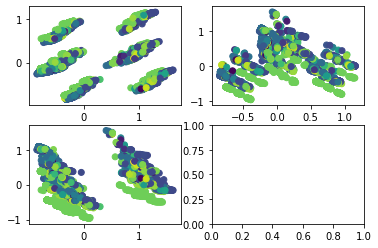

In [23]:
color = df_obj_selected.loc[train_features.index, 'zona'].astype('category').cat.codes
f, ax = plt.subplots(2,2)
ax[0, 0].scatter(arr[:,0], arr[:,1], c=color)
ax[0, 1].scatter(arr[:,1], arr[:,2], c=color)
ax[1, 0].scatter(arr[:,0], arr[:,2], c=color)

In [24]:
lda = LinearDiscriminantAnalysis(n_components=3).fit_transform(df_num_selected.drop(columns=['price']),
                                                              df_num_selected['price'])

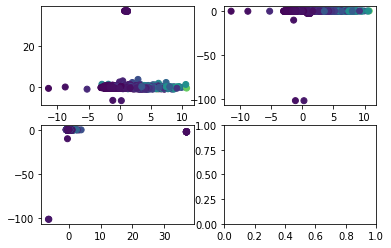

In [25]:
f, ax = plt.subplots(2, 2)
ax[0, 0].scatter(lda[:, 0], lda[:, 1], c=df_num_selected['price'])
ax[0, 1].scatter(lda[:, 0], lda[:, 2], c=df_num_selected['price'])
ax[1, 0].scatter(lda[:, 1], lda[:, 2], c=df_num_selected['price'])


In [26]:
def plot_predict_result(test_price, predict_price):
    f, ax = plt.subplots(2)
    ax[0].scatter(test_price, predict_price)
    ax[0].plot([0, 1600000], [0, 1600000], c='r')
    ax[1].hist(test_price - predict_price, bins=100)

# Linear Model

In [41]:
model = LinearRegression(fit_intercept=True)
model.fit(train_features, train_price)
# model.coef_, model.intercept_, model.rank_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
predict_price = model.predict(test_features)

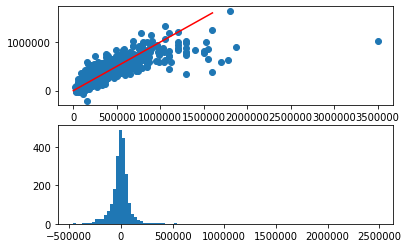

In [29]:
plot_predict_result(test_price, predict_price)

# Regression Tree

In [30]:
cls_tree = DecisionTreeRegressor()
cls_tree.fit(train_features, train_price)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [31]:
predic_price_tree = cls_tree.predict(test_features)

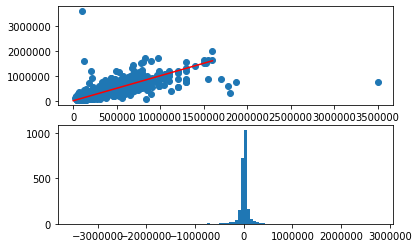

In [32]:
plot_predict_result(test_price, predic_price_tree)

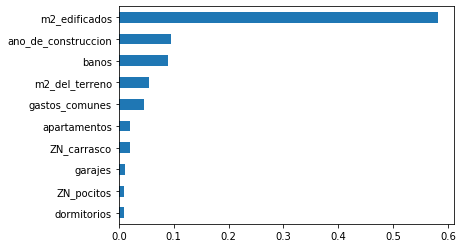

In [36]:
f, ax = plt.subplots()
(pd
 .Series(cls_tree.feature_importances_, index=train_features.columns)
 .sort_values()[-10:]
 .plot(ax=ax, kind='barh')
)